# Libraries and data dir

In [1]:
img_size = 100
img_size_str = str(img_size)
data_dir = "C:/Users/Sean/Desktop/Phytoplankton_Classifier/dataset/SYKE-plankton_IFCB_2022"
processed_data_dir = "dataset/Processed"
split_data_dir = "dataset/Processed_Split"
train_dir = "dataset/Processed_Split/train"
val_dir = "dataset/Processed_Split/val"
test_dir = "dataset/Processed_Split/test"

train_csv_path = "F:/train_" + img_size_str + ".csv"
val_csv_path = "F:/val_" + img_size_str + ".csv"
test_csv_path = "F:/test_" + img_size_str + ".csv"

train_pca_csv_path = "F:/train_pca_" + img_size_str + ".csv"
val_pca_csv_path = "F:/val_pca_" + img_size_str + ".csv"
test_pca_csv_path = "F:/test_pca_" + img_size_str + ".csv"

train_lda_csv_path = "F:/train_lda_" + img_size_str + ".csv"
val_lda_csv_path = "F:/val_lda_" + img_size_str + ".csv"
test_lda_csv_path = "F:/test_lda_" + img_size_str + ".csv"

n_classes = 50

In [3]:
import numpy as np
from scipy import stats
import os
from PIL import Image, ImageFilter, ImageEnhance
import glob
import cv2
from matplotlib import pyplot as plt
import random
from sklearn.decomposition import PCA
import splitfolders
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import tensorflow as tf
import pandas as pd
import csv

In [3]:
# Returns a list of names in list files.
files = glob.glob(data_dir + '/**/*.png', recursive = True)

In [4]:
random.seed(42)

# Examples

In [5]:
num_samples = 5

In [6]:
sample_files = []
sample_outfiles = []
for i in range(num_samples):
    # Choose a random file, set save location
    file = random.choice(files)
    sample_files.append(file)
    dir_name = os.path.basename(os.path.dirname(file))
    file_name = os.path.basename(file)
    process_dir = os.path.join(os.getcwd(), processed_data_dir)
    dir = os.path.join(os.getcwd(), processed_data_dir, dir_name)
    outfile = os.path.join(processed_data_dir, dir_name, file_name)
    if not os.path.isdir(process_dir):
        os.mkdir(process_dir)
    if not os.path.isdir(dir):
        os.mkdir(dir)
    sample_outfiles.append(outfile)

## Resizing while maintaining aspect ratio

Original:  120 82
Resized:  100 68
Original:  176 106
Resized:  100 60
Original:  96 106
Resized:  91 100
Original:  168 34
Resized:  100 20
Original:  96 42
Resized:  96 42


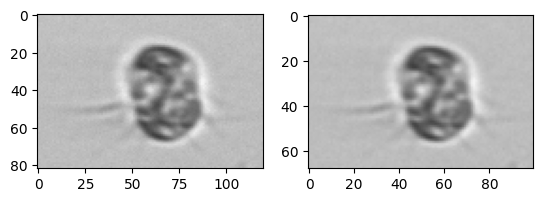

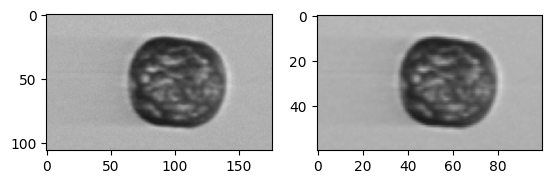

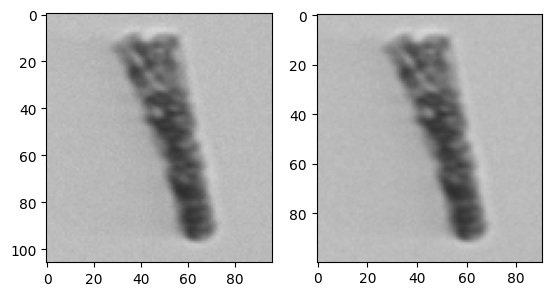

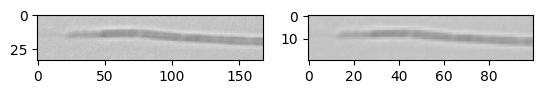

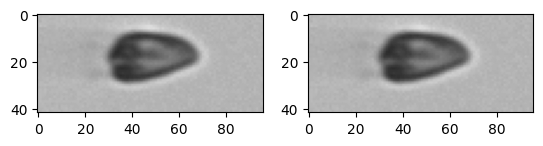

In [7]:
for i in range(num_samples):
    file = sample_files[i]
    outfile = sample_outfiles[i]
    with Image.open(file) as im:
        width, height = im.size
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(im, cmap='gray', vmin=0, vmax=255)
        im.thumbnail((img_size, img_size))
        new_width, new_height = im.size
        axarr[1].imshow(im, cmap='gray', vmin=0, vmax=255)
        print("Original: ", width, height)
        print("Resized: ", new_width, new_height)
        im.save(outfile)

## Padding

C:\Users\Sean\AppData\Local\Temp\ipykernel_13352\2908225113.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = int(stats.mode(array)[0][0])


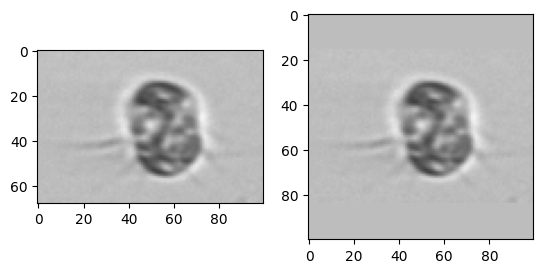

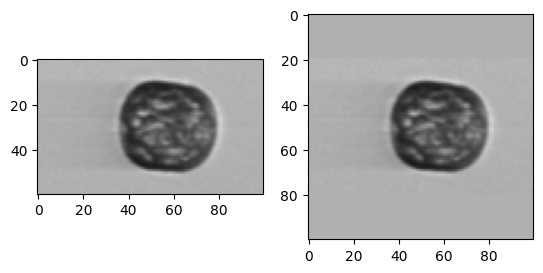

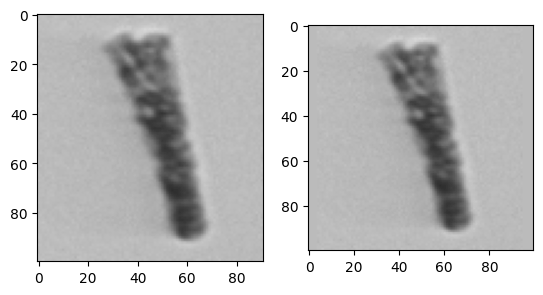

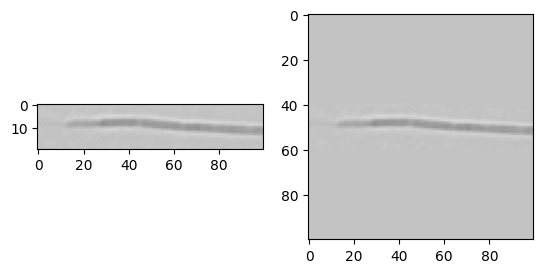

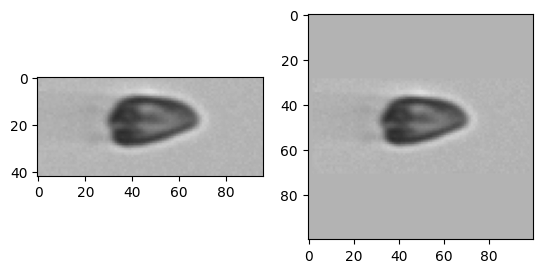

In [8]:
for i in range(num_samples):
    array = []
    outfile = sample_outfiles[i]
    with Image.open(outfile) as im:
        width, height = im.size
        for x in range(0, width):
            for y in range(0, height):
                array.append(im.getpixel((x,y)))
        array = np.array(array)
        mode = int(stats.mode(array)[0][0])
        left = (img_size - width) // 2
        top = (img_size - height) // 2
        new_im = Image.new(im.mode, (img_size, img_size), mode) # im.mode: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
        new_im.paste(im, (left, top))
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(im, cmap='gray', vmin=0, vmax=255)
        axarr[1].imshow(new_im, cmap='gray', vmin=0, vmax=255)
        new_im.save(outfile)

## Denoise

May not look like a lot of difference, but during edge detection, the noise is quite evident.

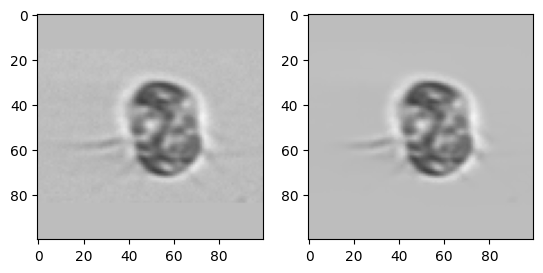

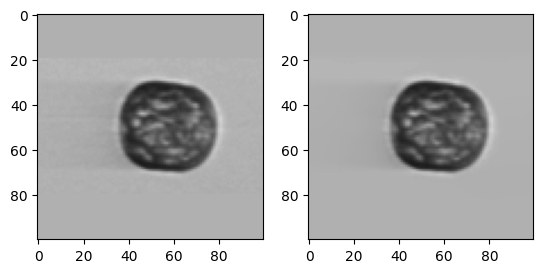

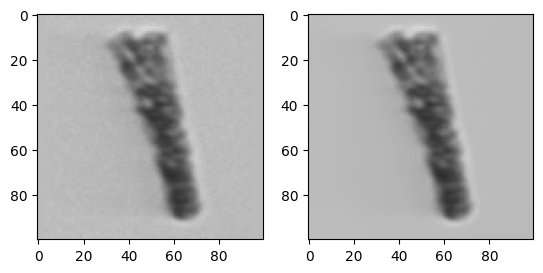

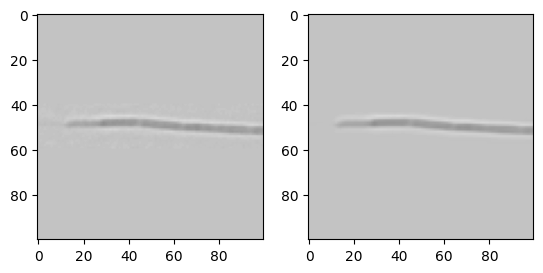

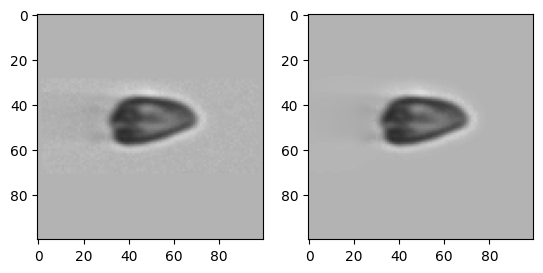

In [9]:
for i in range(num_samples):
    outfile = sample_outfiles[i]
    img = cv2.imread(outfile, cv2.IMREAD_GRAYSCALE)
    dst = cv2.fastNlMeansDenoising(img,None)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    axarr[1].imshow(dst, cmap='gray', vmin=0, vmax=255)
    cv2.imwrite(outfile, dst)

## Edge detection with PIL

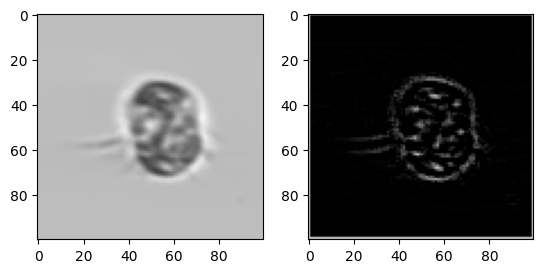

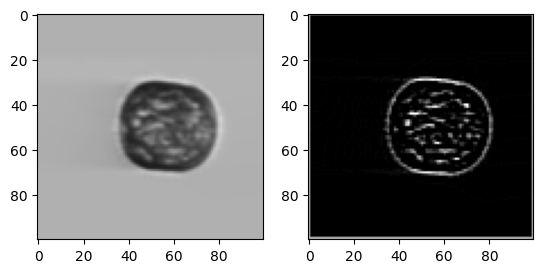

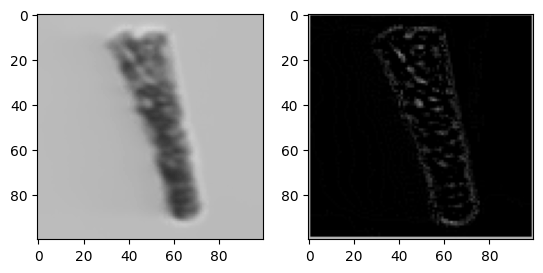

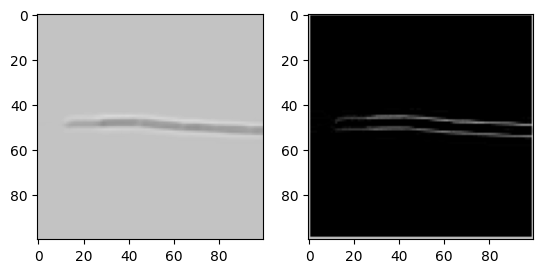

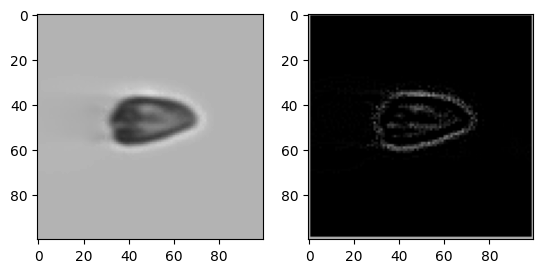

In [10]:
for i in range(num_samples):
    array = []
    outfile = sample_outfiles[i]
    with Image.open(outfile) as im:
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(im, cmap='gray', vmin=0, vmax=255)
        new_im = im.filter(ImageFilter.FIND_EDGES)
        axarr[1].imshow(new_im, cmap='gray', vmin=0, vmax=255)

## Edge detection with opencv

After reading the image, we also blur it, using the GaussianBlur() function. This is done to reduce the noise in the image. In edge detection, numerical derivatives of the pixel intensities have to be computed, and this typically results in ‘noisy’ edges. In other words, the intensity of neighboring pixels in an image (especially near edges) can fluctuate quite a bit, giving rise to edges that don’t represent the predominant edge structure we are looking for. 

Blurring smoothens the intensity variation near the edges, making it easier to identify the predominant edge structure within the image.

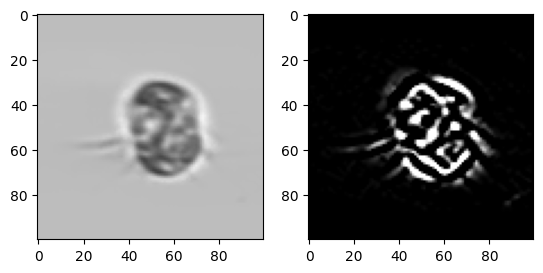

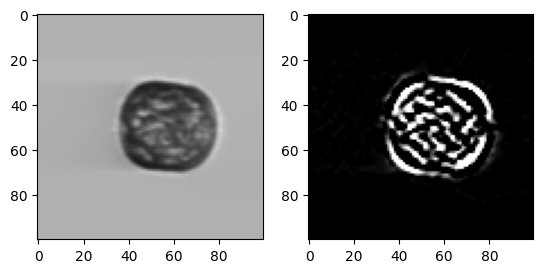

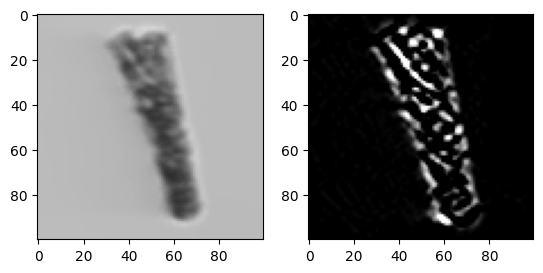

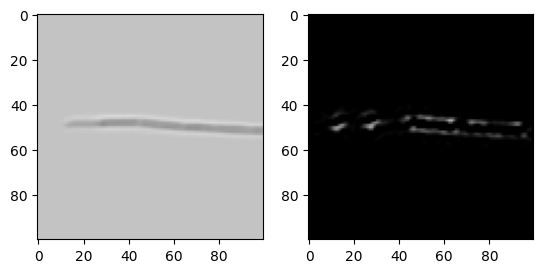

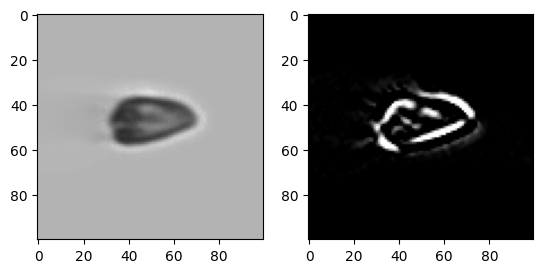

In [11]:
for i in range(num_samples):
    outfile = sample_outfiles[i]
    # Read the original image
    img = cv2.imread(outfile, cv2.IMREAD_GRAYSCALE)
    # Blur the image for better edge detection
    # img_blur = cv2.GaussianBlur(img, (3,3), 0)         
    # Sobel Edge Detection
    # sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_8U, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
    # sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_8U, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
    sobelxy = cv2.Sobel(src=img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    # axarr[1].imshow(img_blur, cmap='gray', vmin=0, vmax=255)
    axarr[1].imshow(sobelxy, cmap='gray', vmin=0, vmax=255)

## Conclusion

1. Resize maintaining aspect ratio for input to cnn
2. Padding with mode of pic because there is a lot of background
3. Denoise to get rid of uninterested regions or unavoidable marine snow
4. Edge detection with PIL seems to be better than with opencv, using visual inspection
5. PCA for SVM, Naive Bayes. Other models should not use this.

# Combining resize, padding, denoise, edge detection

In [15]:
for file in files:
    array = []
    dir_name = os.path.basename(os.path.dirname(file))
    file_name = os.path.basename(file)
    process_dir = os.path.join(os.getcwd(), processed_data_dir)
    dir = os.path.join(os.getcwd(), processed_data_dir, dir_name)
    outfile = os.path.join(processed_data_dir, dir_name, file_name)
    if not os.path.isdir(process_dir):
        os.mkdir(process_dir)
    if not os.path.isdir(dir):
        os.mkdir(dir)
    with Image.open(file) as im:
        # Resizing
        im.thumbnail((img_size, img_size))
        width, height = im.size
        # Padding
        for x in range(0, width):
            for y in range(0, height):
                array.append(im.getpixel((x,y)))
        array = np.array(array)
        mode = int(stats.mode(array)[0][0])
        left = (img_size - width) // 2
        top = (img_size - height) // 2
        new_im = Image.new(im.mode, (img_size, img_size), mode) # im.mode: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
        new_im.paste(im, (left, top))
        new_im.save(outfile)
        # Convert to cv2
        # Denoise
    
    img = cv2.imread(outfile, cv2.IMREAD_GRAYSCALE)
    dst = cv2.fastNlMeansDenoising(img,None)
    cv2.imwrite(outfile, dst)

    with Image.open(outfile) as im:
        new_im = im.filter(ImageFilter.FIND_EDGES)
        new_im.save(outfile)

C:\Users\Sean\AppData\Local\Temp\ipykernel_13352\2234989240.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = int(stats.mode(array)[0][0])


# Train test split

In [17]:
# Train val test
splitfolders.ratio(processed_data_dir, output=split_data_dir, seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)

# Data augmentation for minority classes

Classes with < 100 samples:
31: 'Merismopedia_sp'
2: 'Aphanothece_paralleliformis'
23: 'Gymnodiniales'
22: 'Gonyaulax_verior'
0: 'Amylax_triacantha'
28: 'Katablepharis_remigera'
29: 'Licmophora_sp'
34: 'Nitzschia_paleacea'
5: 'Ceratoneis_closterium'
30: 'Melosira_arctica'
8: 'Chlorococcales'

Horizontal and vertical flipping images will x 3
Brightness change will x 3

In [20]:
# Returns a list of names in list files.
min_files = glob.glob(train_dir + '/**/*.png', recursive = True)

In [21]:
min_classes = ['Merismopedia_sp', 'Aphanothece_paralleliformis', 'Gymnodiniales', 'Gonyaulax_verior', 'Amylax_triacantha', 'Katablepharis_remigera', 'Licmophora_sp', 'Nitzschia_paleacea', 'Ceratoneis_closterium', 'Melosira_arctica', 'Chlorococcales']

## Brightness

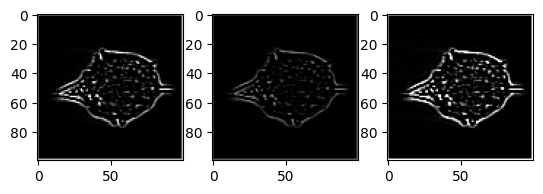

In [29]:
for file in min_files:
    array = []
    dir_name = os.path.basename(os.path.dirname(file))
    file_name = os.path.basename(file)
    # Find minority classes
    if dir_name in min_classes:
        min_path = os.path.join(train_dir, dir_name)
        dir_files = glob.glob(min_path + '/*.png', recursive = True)
        with Image.open(file) as im:
            f, axarr = plt.subplots(1,3)
            # Brightness
            enhancer = ImageEnhance.Brightness(im)
            axarr[0].imshow(im, cmap='gray', vmin=0, vmax=255)
            im_output = enhancer.enhance(0.5)
            axarr[1].imshow(im_output, cmap='gray', vmin=0, vmax=255)
            im_output = enhancer.enhance(1.5)
            axarr[2].imshow(im_output, cmap='gray', vmin=0, vmax=255)
        break

## Flipping

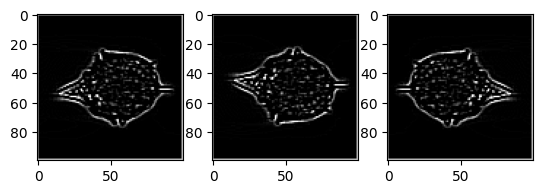

In [30]:
for file in min_files:
    array = []
    dir_name = os.path.basename(os.path.dirname(file))
    file_name = os.path.basename(file)
    # Find minority classes
    if dir_name in min_classes:
        min_path = os.path.join(train_dir, dir_name)
        dir_files = glob.glob(min_path + '/*.png', recursive = True)
        with Image.open(file) as im:
            f, axarr = plt.subplots(1,3)
            # Flipping
            axarr[0].imshow(im, cmap='gray', vmin=0, vmax=255)
            new_im = im.transpose(Image.FLIP_TOP_BOTTOM)
            axarr[1].imshow(new_im, cmap='gray', vmin=0, vmax=255)
            new_im = im.transpose(Image.FLIP_LEFT_RIGHT)
            axarr[2].imshow(new_im, cmap='gray', vmin=0, vmax=255)
        break

## Combining both Flipping and Brightness

In [28]:
def get_outfile(j, min_path, file_name):
    outfile = os.path.join(min_path, file_name)
    # Splitext to remove extension
    # Add new extension
    outfile = os.path.splitext(outfile)[0] + "_" + str(j) + ".png"
    j += 1
    return outfile, j

for file in min_files:
    array = []
    dir_name = os.path.basename(os.path.dirname(file))
    file_name = os.path.basename(file)
    # Find minority classes
    if dir_name in min_classes:
        j = 0
        min_path = os.path.join(train_dir, dir_name)
        dir_files = glob.glob(min_path + '/*.png', recursive = True)
        with Image.open(file) as im:
            # Brightness
            enhancer = ImageEnhance.Brightness(im)
            im_output = enhancer.enhance(0.5)
            outfile, j = get_outfile(j, min_path, file_name)
            im_output.save(outfile)
            
            im_output = enhancer.enhance(1.5)
            outfile, j = get_outfile(j, min_path, file_name)
            im_output.save(outfile)

            # Flipping
            new_im = im.transpose(Image.FLIP_TOP_BOTTOM)
            outfile, j = get_outfile(j, min_path, file_name)
            new_im.save(outfile)

            new_im = im.transpose(Image.FLIP_LEFT_RIGHT)
            outfile, j = get_outfile(j, min_path, file_name)
            new_im.save(outfile)

# Create CSV

In [ ]:
# Remove file if exists
if os.path.exists(train_csv_path):
    os.remove(train_csv_path)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  seed=42,
  color_mode="grayscale",
  batch_size=None,
  image_size=(img_size,img_size))

with open(train_csv_path, 'a', newline='') as f:
    writer = csv.writer(f)
    for image, labels in train_ds:
        row = np.append(image.numpy().flatten(),labels.numpy().flatten()[0])
        writer.writerow(row)

df = pd.read_csv(train_csv_path, header=None)
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

X_train = StandardScaler().fit_transform(X_train) # normalizing the features

Found 45828 files belonging to 50 classes.


In [ ]:
# Remove file if exists
if os.path.exists(val_csv_path):
    os.remove(val_csv_path)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels="inferred",
  seed=42,
  color_mode="grayscale",
  batch_size=None,
  image_size=(img_size,img_size))

with open(val_csv_path, 'a', newline='') as f:
    writer = csv.writer(f)
    for image, labels in val_ds:
        row = np.append(image.numpy().flatten(),labels.numpy().flatten()[0])
        writer.writerow(row)

df = pd.read_csv(val_csv_path, header=None)
X_val = df.iloc[:,:-1]
y_val = df.iloc[:,-1]

X_val = StandardScaler().fit_transform(X_val) # normalizing the features


Found 9438 files belonging to 50 classes.


In [ ]:
# Remove file if exists
if os.path.exists(test_csv_path):
    os.remove(test_csv_path)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels="inferred",
  seed=42,
  color_mode="grayscale",
  batch_size=None,
  image_size=(img_size,img_size))

with open(test_csv_path, 'a', newline='') as f:
    writer = csv.writer(f)
    for image, labels in test_ds:
        row = np.append(image.numpy().flatten(),labels.numpy().flatten()[0])
        writer.writerow(row)

df = pd.read_csv(test_csv_path, header=None)
X_test = df.iloc[:,:-1]
y_test = df.iloc[:,-1]

X_test = StandardScaler().fit_transform(X_test) # normalizing the features

Found 9504 files belonging to 50 classes.


# PCA

Only for Naive Bayes, SVM

In [3]:
import tensorflow as tf
import pandas as pd
import csv

## Train

In [7]:
pca = PCA(n_components=100, random_state=10)

In [8]:
X_train_pca = pca.fit_transform(X_train)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.04740183 0.04021532 0.02037982 0.01246176 0.01091413 0.00853545
 0.00784076 0.00679684 0.00551041 0.00527479 0.00497656 0.0048972
 0.00436803 0.00399752 0.00396298 0.00368244 0.00349316 0.00342975
 0.00324851 0.00314146 0.0030903  0.00298187 0.00292541 0.00280856
 0.00273594 0.00265039 0.00259433 0.00252599 0.00248191 0.00241401
 0.00240451 0.00234332 0.00232333 0.0023002  0.00224181 0.0022081
 0.00216849 0.00213699 0.002105   0.00208108 0.00202324 0.00201582
 0.00197678 0.00196364 0.0019439  0.00191878 0.00190043 0.00187359
 0.00183249 0.00182429 0.00179319 0.00175514 0.00174423 0.00173536
 0.00170044 0.00169088 0.00165853 0.00164082 0.00163355 0.00161
 0.00159856 0.00157712 0.00155765 0.00153485 0.00152413 0.0015147
 0.00149728 0.0014645  0.00145678 0.00144262 0.00143652 0.00142434
 0.00141373 0.00140014 0.00139504 0.00137681 0.00135863 0.00134905
 0.00133761 0.00133573 0.00132446 0.00131289 0.00130889 0.00129767
 0.00128528 0.00127354 

In [9]:
sum(pca.explained_variance_ratio_)

0.3438506604708242

In [10]:
X_train_pca = pd.DataFrame(X_train_pca)
train_df = pd.concat([X_train_pca,y_train], axis = 1)
train_df.to_csv(train_pca_csv_path, index=False, header=False)

## Val

In [11]:
X_val_pca = pca.transform(X_val)
X_val_pca = pd.DataFrame(X_val_pca)

In [12]:
val_df = pd.concat([X_val_pca,y_val], axis = 1)
val_df.to_csv(val_pca_csv_path, index=False, header=False)

## Test

In [13]:
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca)

In [14]:
test_df = pd.concat([X_test_pca,y_test], axis = 1)
test_df.to_csv(test_pca_csv_path, index=False, header=False)

# LDA

Only for Naive Bayes, SVM

In [4]:
print(min(n_classes - 1, img_size*img_size))
lda = LinearDiscriminantAnalysis(n_components=min(n_classes - 1, img_size*img_size))

49


## Train

In [5]:
df = pd.read_csv(train_csv_path, header=None)
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

In [6]:
X_train = StandardScaler().fit_transform(X_train) # normalizing the features

In [7]:
X_train_lda = lda.fit_transform(X_train, y_train)
print('Explained variation per principal component: {}'.format(lda.explained_variance_ratio_))

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
sum(lda.explained_variance_ratio_)

0.3438506604708242

In [ ]:
X_train_lda = pd.DataFrame(X_train_lda)

In [ ]:
train_df = pd.concat([X_train_lda,y_train], axis = 1)
train_df.to_csv(train_lda_csv_path, index=False, header=False)

## Val

In [ ]:
df = pd.read_csv(val_csv_path, header=None)
X_val = df.iloc[:,:-1]
y_val = df.iloc[:,-1]

In [ ]:
X_val = StandardScaler().fit_transform(X_val) # normalizing the features

In [ ]:
X_val_lda = lda.transform(X_val)
X_val_lda = pd.DataFrame(X_val_lda)

In [ ]:
val_df = pd.concat([X_val_lda,y_val], axis = 1)
val_df.to_csv(val_lda_csv_path, index=False, header=False)

## Test

In [ ]:
df = pd.read_csv(test_csv_path, header=None)
X_test = df.iloc[:,:-1]
y_test = df.iloc[:,-1]

In [ ]:
X_test = StandardScaler().fit_transform(X_test) # normalizing the features

In [ ]:
X_test_lda = lda.transform(X_test)
X_test_lda = pd.DataFrame(X_test_lda)

In [ ]:
test_df = pd.concat([X_test_lda,y_test], axis = 1)
test_df.to_csv(test_lda_csv_path, index=False, header=False)